In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
from collections import defaultdict
import tqdm

In [78]:
df = pd.read_csv('data/sample_df.csv')

In [83]:
df.drop(columns=['Unnamed: 0','index','rating_y'],inplace=True)
df.columns = ['item','user','rating','timestamp']

In [84]:
df

,item,user,rating,timestamp
0,0972683275,A1MNILX1J1NWV7,4.0,1464825600
1,0972683275,A1JPB4BJHNCSWR,5.0,1409184000
2,0972683275,A2A3B0JX2JRS6S,5.0,1379462400
3,0972683275,A2BLGQ2SCSKCCY,5.0,1358812800
4,0972683275,A21OS6PWQG5YOO,5.0,1337904000
...,...,...,...,...
95795,B01H4OYJNI,A2QIFKUBK053ZC,5.0,1531008000
95796,B01H4YTHWG,A2SOSDOBI6AHJI,5.0,1537920000
95797,B01H4ZLZLQ,A3CHC46D65IH4H,4.0,1536019200
95798,B01HGV7M7Y,A1F7KIIWHPQ5TG,5.0,1537142400


In [85]:
user = df['user'].unique()
item = df['item'].unique()

In [86]:
#generating history of an user
historic_users = []
for i,u in enumerate(tqdm.tqdm(user)):
    temp = df[df['user']==u]
    temp = temp.sort_values('timestamp').reset_index(drop=True)
    historic_users.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3821/3821 [00:21<00:00, 181.64it/s]


In [89]:
#add index to timestamp to avoid repeating same timestamp for a user
for user in historic_users:
    user['timestamp'] = user['timestamp'] + user.index

In [90]:
lengths = []
for user in historic_users:
    lengths.append(len(user))

(array([2347.,  842.,  341.,  162.,   52.,   40.,   17.,    9.,    5.,
           6.]),
 array([20. , 24.8, 29.6, 34.4, 39.2, 44. , 48.8, 53.6, 58.4, 63.2, 68. ]),
 <BarContainer object of 10 artists>)

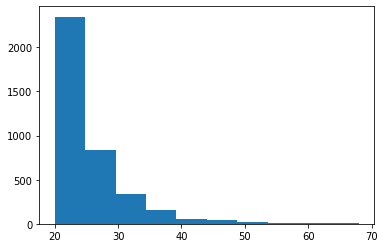

In [91]:
import matplotlib.pyplot as plt
plt.hist(lengths)

In [96]:
def sample_history_generator(user_history,min_num_states,min_num_actions,states_ratio,sample_size = 10):
    n = len(user_history)
    sep_ratio = int(states_ratio * n)
    nb_states = []
    nb_actions = []
    nb_states = [np.random.randint(min_num_states,sep_ratio) for i in range(sample_size)]
    nb_actions = [min_num_actions for i in range(sample_size)]
    states = []
    actions = []
    for i in range(len(nb_states)):
        sample_states = user_history.iloc[0:sep_ratio].sample(nb_states[i])
        sample_state = []
        sample_action = []
        for j in range(nb_states[i]):
            row = sample_states.iloc[j]
#             state = str(row.loc['item']) + '&' + str(row.loc['rating'])
            state = str(row.loc['item'])
            sample_state.append(state)            
        row = user_history.iloc[-(n - sep_ratio):].sample(nb_actions[i])
#             action = str(row.loc['item']) + '&' + str(row.loc['rating'])
        action = str(row['item'].item())
        sample_action.append(action)
        states.append(sample_state)
        actions.append(sample_action)
    return states,actions

In [97]:
min_num_states = 12
min_actions = 1
states_ratio = 0.7
sample_size = 10
sequence_dict = defaultdict(list)
for i,users in enumerate(tqdm.tqdm(historic_users)):
    states,actions = sample_history_generator(users,min_num_states,min_actions,states_ratio,sample_size)
    for i in range(len(states)):
        state_str = '|'.join(states[i])
        action_str = actions[i][0]
        next_state_str = state_str + '|' + action_str
        sequence_dict['state'].append(state_str)
        sequence_dict['action_reward'].append(action_str)
        sequence_dict['next_state'].append(next_state_str)
sequence_df = pd.DataFrame(sequence_dict)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3821/3821 [00:46<00:00, 82.89it/s]


In [98]:
sequence_df.action_reward.nunique()

7255

In [102]:
sequence_df

,state,action_reward,next_state
0,B003ZX8B2S|B005LS2HM0|B00DZ6R9GE|B00RM6Q5HM|B0...,B00QQ7SG48,B003ZX8B2S|B005LS2HM0|B00DZ6R9GE|B00RM6Q5HM|B0...
1,B009QFKFWS|B004GF8TIK|B00QMSMK4S|B003ZX8B2S|B0...,B006HW5E5Q,B009QFKFWS|B004GF8TIK|B00QMSMK4S|B003ZX8B2S|B0...
2,B00RM6Q5HM|B00829TIIQ|B003ZX8B2S|B00DYQYLQQ|B0...,B00QQ7SG48,B00RM6Q5HM|B00829TIIQ|B003ZX8B2S|B00DYQYLQQ|B0...
3,B009381N2E|B004GF8TIK|B003ZX8B2S|B00GHY5JAO|B0...,B006HW5E5Q,B009381N2E|B004GF8TIK|B003ZX8B2S|B00GHY5JAO|B0...
4,B004GF8TIK|B00GHY5JAO|B015PYZ0J6|B005LS2HM0|B0...,B00ODEGWN8,B004GF8TIK|B00GHY5JAO|B015PYZ0J6|B005LS2HM0|B0...
...,...,...,...
38205,B015KTJ5KG|B00LIX177I|B011WBI4S0|B00KFFUWJE|B0...,B016QVZEYI,B015KTJ5KG|B00LIX177I|B011WBI4S0|B00KFFUWJE|B0...
38206,B01421DST2|B00OAJ412U|B00FR795WA|B010MS67ZG|B0...,B016QVZEYI,B01421DST2|B00OAJ412U|B00FR795WA|B010MS67ZG|B0...
38207,B00KFFUWJE|B011WBI4S0|B00NBR70A2|B00IO3HB2K|B0...,B00VAYIWSM,B00KFFUWJE|B011WBI4S0|B00NBR70A2|B00IO3HB2K|B0...
38208,B015KTJ5KG|B00JR2V0SS|B00KFFUWJE|B010MS67ZG|B0...,B013HSW4N2,B015KTJ5KG|B00JR2V0SS|B00KFFUWJE|B010MS67ZG|B0...


In [48]:
df.item.nunique()

13283